<a href="https://colab.research.google.com/github/drewlinsley/colabs/blob/master/DNN_scrape_and_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. DISCoV 2/7/19**
You can find the [presentation link here](https://docs.google.com/presentation/d/1pJi1fPt7i7enJAClSVkPOw3pl515YN0Q44kvO8zSpdc/edit?usp=sharing).

**1. Python imports.**

Let's split this into separate blocks for clarity.

Here, you will import `drive` from the google colab library for connecting to [google drive](https://github.com/googlecolab/colabtools/blob/master/google/colab/drive.py) and `files` for [uploading local files](https://github.com/googlecolab/colabtools/blob/master/google/colab/files.py) (i.e. your machine) to this kernel. Finally, MediaFileUpload is a class for more efficient [uploads](https://github.com/googleapis/google-api-python-client/blob/master/googleapiclient/http.py). 

In [1]:
using_colab = False

In [2]:
if using_colab:
    from google.colab import drive
    from google.colab import files as cfiles
    from googleapiclient.http import MediaFileUpload


In [3]:
import numpy as np  # Note numpy is aliased as np
from PIL import Image
import os
import shutil
from glob import glob  # File path collection
import tensorflow as tf  # Note tensorflow is aliased as tf
from matplotlib import pyplot as plt  # Library for plotting images

# Keras model utilities
from keras.models import Model  # A Keras class for constructing a deep neural network model
from keras.models import Sequential  # A Keras class for connecting deep neural network layers 
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator  # A class for data loading during model training

# Keras ResNet routines
from keras.applications.resnet50 import ResNet50  # Import the ResNet deep neural network
from keras.preprocessing import image  # Routines for loading image data
from keras.applications.resnet50 import preprocess_input  # ResNet-specific routines for preprocessing images
from keras.applications.resnet50 import decode_predictions  # ResNet-specific routines for extracting predictions

# Keras layers
from keras.layers import Dense  # A fully connected neural networld layer
from keras.layers import Activation  # A class for point-wise nonlinearity layers
from keras.layers import Flatten  # Reshape a tensor into a matrix
from keras.layers import Dropout  # A regularization layer which randomly zeros neural network units during training.

# Optimizers
from keras.optimizers import Adam  # Adam optimizer https://arxiv.org/abs/1412.6980
from keras.optimizers import SGD  # Stochastic gradient descent optimizer

Using TensorFlow backend.


We will also install the google_images_download library to scrape images from websites. Later, we will pass these images through trained deep neural networks.

See how we can install libraries in python using the `pip` command. This is the python package manager, and is typically called with : `pip install my_package`. Note that because we are using the jupyter/ipython interface, we have to prepend an exclamation point `!` to call pip with the command line interpreter.

In [4]:
!pip install google_images_download
from google_images_download import google_images_download   #importing the library

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


**2. Set global variables**

This is not "good programming practice" under typical circumstances, but it is reasonable for python notebooks. So bear with me.

We will set global variables (paths, etc.) and mount google drive here.

In [5]:
def make_dir(d):
    """Make directory d if it does not exist."""
    if not os.path.exists(d):
        os.makedirs(d)


ROOT_DIR = "."
if using_colab:
    ROOT_DIR = "/content"
    drive.mount("/content/gdrive")

IMG_DIR  = "%s/image_dataset" % ROOT_DIR
PROC_DIR = "%s_processed" % IMG_DIR
print("TensorFlow version: " + tf.__version__)

make_dir(IMG_DIR)
make_dir(PROC_DIR)

# If necessary, clear out the directories
# !rm -rf IMG_DIR
# !rm -rf PROC_DIR

TensorFlow version: 1.12.0


**3. Download images for your DNN.**

Using the google_images_download library, scrape images related to whatever you'd like. Later, we will pass these images through a deep neural network, and evaluate what it sees.

To scrape images, you will provide a python dictionary with key/value pairs that are interpreted by the library. These include a comma-delimeted list of keywords of what image categories to scrape for, a per-category image limit, a boolean for whether or not to print progress, and an output directory. Feel free to change any of these. [Follow this link for the full api.](https://github.com/hardikvasa/google-images-download/blob/master/google_images_download/google_images_download.py#L66)

N.B. This code block may fail due to issues with meta data for some images that causes errors in the google web scraper. If it fails, simply retry the code block until it completes.

In [6]:
def pad_name(f, padding=3):
  """Zero pad a string"""
  if not isinstance(f, basestring):
    f = str(f)
  fl = len(f)
  ll = padding - fl
  for p in range(ll):
    f = '0' + f
  return f

height     = 224
width      = 224
class_list = ["cat", "dog", "bird", "turtle", "cheetah"]  # Categories of object images
response = google_images_download.googleimagesdownload()   # Class instantiation
arguments = {
  "keywords": ",".join(class_list),
  "limit": 10,
  "print_urls": False,
  "format": "jpg",
  "type": "photo",
  "color_type": "full-color",
  "output_directory": IMG_DIR
}
paths = response.download(arguments)   # Passing the arguments to the function
# print(paths)   # Print absolute paths of the downloaded images

# Copy files to PROC_DIR into the Keras expected format
categories = glob(IMG_DIR + '/*')
files = []
for cat in categories:
  it_dir = "%s/%s" % (PROC_DIR, cat.split('/')[-1])
  make_dir(it_dir)
  print('Filling directory: %s' % it_dir)
  tfiles = glob(cat + '/*.jpg')
  for idx, f in enumerate(tfiles):
    try:
      # Filter to make sure they can load in keras
      img = image.load_img(f, target_size=(height, width))
      path = "%s%s%s.jpg" % (it_dir, os.path.sep, pad_name(idx))
      shutil.copy2(f, path)
      files += [path]
    except Exception as e:
      print '%s %s is not an image: %s' % (cat, idx, f)
print files




Item no.: 1 --> Item name = cat
Evaluating...
Starting Download...
Completed Image ====> 1. 02-cat-training-nationalgeographic_1484324.jpg
Completed Image ====> 2. photo-1518791841217-8f162f1e1131?ixlib=rb-1.2.1&ixid=eyjhchbfawqiojeymdd9&w=1000&q=80.jpg
Completed Image ====> 3. 5acb63d83493f__700-png.jpg
Completed Image ====> 4. cat-217679.jpg
Completed Image ====> 5. savannah-cat-long-body-shot.jpg
Completed Image ====> 6. 1200px-cat03.jpg
Completed Image ====> 7. a-fluffy-cat-looking-funny-surprised-or-concerned.jpg
Completed Image ====> 8. cat_eating_fancy_ice_cream.jpg
Completed Image ====> 9. 1*monni1lg9vuiqovpnyqica.jpeg
Completed Image ====> 10. 4-ways-cheer-up-depressed-cat.jpg

Errors: 0


Item no.: 2 --> Item name = dog
Evaluating...
Starting Download...
Completed Image ====> 1. collage_of_nine_dogs.jpg
Completed Image ====> 2. welcome.jpg
Completed Image ====> 3. ?url=https%3a%2f%2fvetstreet-brightspot.s3.amazonaws.com%2f8e%2f4e3910c36111e0bfca0050568d6ceb%2ffile%2fhub-dogs

**3. Load a pretrained ResNet dnn and process an image.**

We take advantage of Keras and use its built in ResNet50 model -- a near state-of-the-art 50-layer object classification model, that has been trained on millions of images. You can load this model by initializing the ResNet50 class with the weights-argument set to `imagenet` (the name of the large-image dataset used for training).

Since we aggregated paths of our scraped images in the variable `files` in the previous code block, we will begin by loading the first of those images into memory, then passing it into the model.

A few comments:



*   See how we have to specify `target_size` in the `load_img` method? This is because the ResNet50 model was trained on images of this size. The method will "center crop" images to this size after loading them.
*   After loading the image, you convert it into an array for processing by Keras and add a singleton dimension to the first axis. The resulting image tensor will have shape `batch/height/width/channels`, or 1/224/224/3. We have to do this because the model was trained on image batches (i.e., multiple images of 224/224/3 size).
*   Finally, the image is preprocessed by subtracting off the imagenet dataset mean value from its red/green/blue channels.  
*   The model has a 1000-dimension output, corresponding to the probability that the image belongs to any of 1000 categories that are in the imagenet dataset. The function decode_predictions returns the category names corresponding to the models predictions.



('Predicted: ', [(u'n02130308', u'cheetah', 0.9959384), (u'n02129165', u'lion', 0.00153893), (u'n02128385', u'leopard', 0.0008688704)])


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


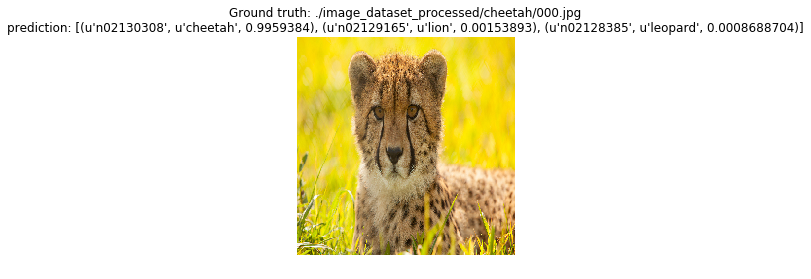

In [7]:
base_model = ResNet50(weights="imagenet")

img = image.load_img(files[0], target_size=(height, width))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = base_model.predict(x)
top_3 = decode_predictions(preds, top=3)[0]
print("Predicted: ", top_3)

f = plt.figure()
plt.imshow(img)
plt.grid('off')
plt.axis('off')
plt.title("Ground truth: %s\nprediction: %s" % (files[0], top_3))
plt.show()
plt.close(f)

**4. Initialize model and train with different sized images.**

We might want to take this model and retrain it on some other task.

This involves a few steps called model "fine tuning". We first reload the model but with the argument "include_top" set to False. This will load the model without its pretrained 1000-category classifier. The rest of the model uses convolutions -- sliding filters -- and by cutting off this top classifier we can map these filter responses to another task.

Note how here we also change the input image size. We can do this because the model is fully convolutional until the final layer, where there is a spatially global pooling, followed by a linear readout. See below:

![ResNet Architecture](https://cdn-images-1.medium.com/max/2100/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg)

Compare the 34-layer residual network to the classic "VGG-19" network, which uses a cascade of fully connected layers to render decisions. 


In [8]:
base_model = ResNet50(
  weights='imagenet', 
  include_top=False, 
  input_shape=(height, width, 3))

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


**5. Augmentations**

CNNs are very sample inefficient: they need to be exposed to large amounts of image-level variability to reach their potential in image classification. This is because CNNs have very weak biases about natural images, relying only on convolutions that implement local-weight sharing.

Image datasets can be augmented with all sorts of transformations to expose CNNs to more variability and improve performance. You can do this easily in Keras with the built-in  [ImageDataGenerator class](https://keras.io/preprocessing/image/).

We set our batch size to 32 (the number of images we process at once during training), since this is a minimal size to use in a model that incorporates so-called "batch normalization" (like the ResNet).



In [9]:
batch_size = 32  # Number of images to process at once

train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=90,
  horizontal_flip=True,
  vertical_flip=True
 )

train_generator = train_datagen.flow_from_directory(
  PROC_DIR, 
  target_size=(height, width),
  batch_size=batch_size)
!ls /content/image_dataset_processed/

Found 47 images belonging to 5 classes.
ls: cannot access '/content/image_dataset_processed/': No such file or directory


** 6. "Finetune" a trained model for your task**
Now we put the pieces together and create the new model for fine tuning.

We build a function `build_fintune_model` that will add classifier layers (you can increase the number of these by adding numbers to the `FC_LAYERS` list) and prepare your model for finetuning. This also includes fixing the pretrained convolutional layers so that they can no longer be trained.

We also include dropout, which is an effective regularizer for CNNs.

In [10]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes, freeze=True):
  """Load pretrained model, add readout layer, fix the convolutional layers."""
  if freeze:
    for layer in base_model.layers:
      layer.trainable = False

  x = base_model.output
  x = Flatten()(x)
  for fc in fc_layers:
    # New FC layer, random init
    x = Dense(fc, activation='relu')(x) 
    x = Dropout(dropout)(x)

  # New softmax layer
  predictions = Dense(num_classes, activation='softmax')(x) 
  
  finetune_model = Model(inputs=base_model.input, outputs=predictions)

  return finetune_model

FC_LAYERS  = [32]  # Add more layers but adding elements to this list
dropout    = 0.5

finetune_model = build_finetune_model(
  base_model, 
  dropout=dropout, 
  fc_layers=FC_LAYERS, 
  num_classes=len(class_list))
print(finetune_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

**7. Save performance and plot results.**

See [the tutorial here ](https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q)for instructions on interacting with your mounted google drive and storing your work there.



In [ ]:
def plot_training(history, plot_val=False):
  """Plot the training and validation loss + accuracy"""
  acc = history.history['acc']
  # val_acc = history.history['val_acc']
  loss = history.history['loss']
  # val_loss = history.history['val_loss']
  epochs = range(len(acc))

  f = plt.figure()
  plt.subplot(121)
  plt.plot(epochs, acc, label='Train')
  if plot_val:
    plt.plot(epochs, val_acc, label='Val')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, label='Train')
  if plot_val:
    plt.plot(epochs, val_loss, label='Val')
  plt.title('Training and validation loss')
  plt.legend()
  plt.savefig('acc_vs_epochs.png')
  plt.show()


epochs = 10  # How many loops through the entire dataset
num_train_images = len(files)
lr = 1e-4
adam = Adam(lr=lr)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="%s/fietuned_ResNet50_model_weights.h5" % ROOT_DIR
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]  # Iteratively executed during training

history = finetune_model.fit_generator(
  train_generator,
  epochs=epochs,
  workers=8,
  steps_per_epoch=num_train_images // batch_size,
  shuffle=True,
  callbacks=callbacks_list)

plot_training(history)


Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 2.8277 - acc: 0.3438

Epoch 00001: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 2/10
1/1 [==============================] - 1s 810ms/step - loss: 2.5180 - acc: 0.1333

Epoch 00002: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 3/10
1/1 [==============================] - 0s 245ms/step - loss: 2.3964 - acc: 0.2812

Epoch 00003: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 4/10
1/1 [==============================] - 0s 132ms/step - loss: 1.8525 - acc: 0.3333

Epoch 00004: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 5/10
1/1 [==============================] - 0s 309ms/step - loss: 1.8577 - acc: 0.2812

Epoch 00005: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 6/10
1/1 [==============================] - 0s 153ms/step - loss: 1.2030 - acc: 0.6667

Epoch 00006: saving model to ./fietuned_ResNet50_model_weights.h5
Epoch 7/10
1/1 [===========================

---
**Exercises**


---

1. Compare the ResNet with other models build into Keras. You can find those [here](https://keras.io/applications/).

2. How does changing the Adam learning rate influence your finetuning performance? What if you swap in a different Keras [optimizer](https://keras.io/optimizers/)?

3. What happens to finetuning performance when you add more than one classifier layer?

4. What kinds of data augmentations help? What kinds hurt?

5. Does dropout help fine tuning? 

6. Why is it normal to "freeze" convolutional layers when training a new classifier on top? What happens when you do not freeze these layers?

7. Can you figure out how to extract and plot filters from the network?